In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import time
from math import exp
from tqdm import tqdm

from rg.monotone import MLP

from rbm.rbm import RBM
from rbm.adjacency_matrices import *
from rbm.coupling_matrices import *

from utils.losses import contrastive_divergence
from utils.newton import find_root
from utils.hmc import HMC
from utils.grad import batch_grad, grad, jacobian
from utils.plots import plot1d, plot2d, vector_field

In [2]:
device = torch.device('cuda')

# Models

In [3]:
representation = 'a1'

if representation == 'a1':
    n_couplers = 1
    coupling_matrix = a1
elif representation == 'a1e':
    n_couplers = 1
    coupling_matrix = a1e

In [4]:
flow = MLP(
    in_dim=n_couplers, 
    out_dim=n_couplers, 
    hidden_depth=n_couplers, 
    width=32 * n_couplers, 
    device=device
)
flow.eval()

sum(p.numel() for p in flow.parameters() if p.requires_grad)

1281

In [6]:
fine = RBM(lieb_square, coupling_matrix, device=device)
coarse = RBM(lieb_cross, coupling_matrix, device=device)

In [9]:
sampler = HMC(device=device)

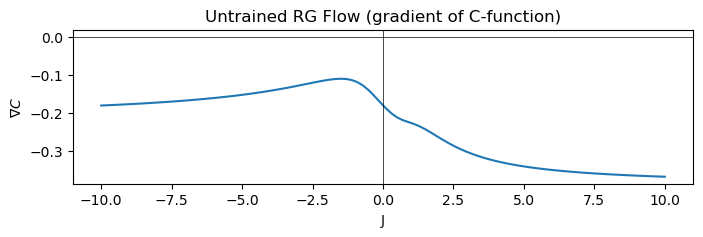

In [10]:
if n_couplers == 1:
    fig, ax = plot1d(flow, xlim=(-10, 10), device=device)
    ax.set_ylabel(r'$\nabla C$')
    ax.set_xlabel('J')
    ax.set_title('Untrained RG Flow (gradient of C-function)')
elif n_couplers == 2:
    
    ax = vector_field(flow, xlim=(-4, 4), ylim=(-4, 4), device=device)

    ax.set_xlabel(r'$J_{A_1}$')
    ax.set_ylabel(r'$J_{E}$')
    ax.set_title(r'Pre-learning RG $\beta$-function')

# Training

In [11]:
epoch = 0
epochs = 1024
anneal_at = 512
n_models = 128 * n_couplers
n_cd_samples = 1024
k_fine = 32
k_coarse = 1

In [12]:
optimizer = torch.optim.Adam(flow.parameters())

Js = []
losses = []
roots = []

J = torch.randn(n_models, n_couplers, device=device)

In [13]:
beta = lambda epoch : 32/(1 + exp( -16 * (epoch - anneal_at) / epochs ))

In [14]:
flow.train()
for epoch in tqdm(range(epoch, epoch + epochs)):
    optimizer.zero_grad()

    sampler.potential = lambda J : beta(epoch) * (flow(J) ** 2).sum(-1)

    # RG Flow
    J = sampler.step(J).detach()

    fine.J = J
    coarse.J = J + flow(J)

    # Loss
    loss = contrastive_divergence(
        fine, coarse, 
        batch_size=n_cd_samples, 
        k_fine=k_fine, 
        k_coarse=k_coarse
    )
    loss.backward()
    optimizer.step()

    Js.append(J.cpu().detach())
    losses.append(float(loss))

    #root = find_root(flow, torch.tensor([0.8, 0., 0., 0., 0.], device=device)).reshape(1, n_couplers)
    #if torch.all(torch.logical_and(root > -2, root < 2)): 
    #    roots.append(root.cpu().detach())
    #else:
    #    roots.append(torch.empty_like(root).fill_(float('nan')).cpu())

100%|███████████████████████████████████████| 1024/1024 [00:22<00:00, 44.67it/s]


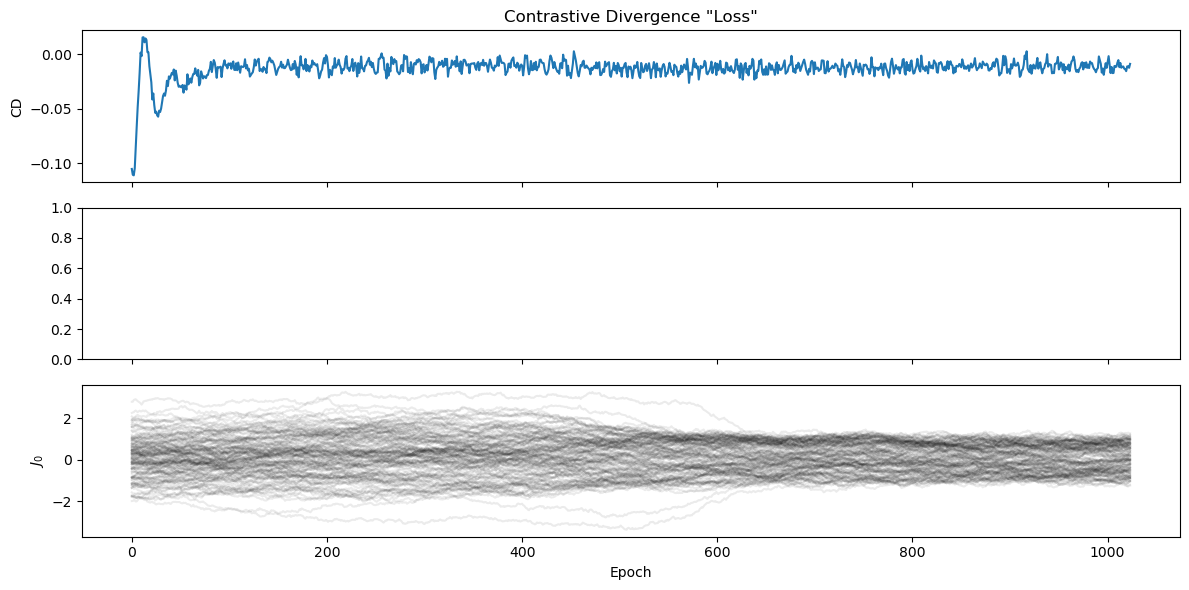

In [15]:
fig, axs = plt.subplots(n_couplers + 2, 1, figsize=(12, n_couplers * 2 + 4), sharex=True)

axs[0].plot(losses)
axs[0].set_ylabel('CD')
axs[0].set_title('Contrastive Divergence "Loss"')

if len(roots) != 0:
    roots_tensor = torch.cat(roots)
    axs[1].plot(roots_tensor[:, 0])
    axs[1].set_ylabel(r'$J_c$')
    axs[1].set_title('Critical Point')

for traj in torch.stack(Js, dim=2):
    for i in range(2, n_couplers+2):
        axs[i].plot(traj[i-2].cpu().detach(), alpha=10/n_models, c='black')
        axs[i].set_ylabel(rf'$J_{i-2}$')

axs[-1].set_xlabel('Epoch')

plt.tight_layout()

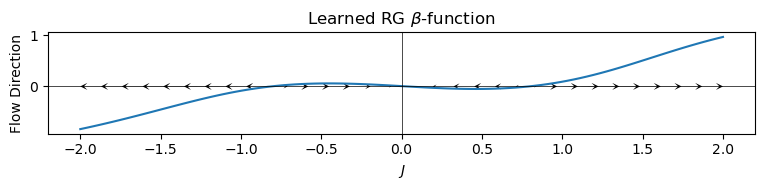

In [16]:
flow.eval()

if n_couplers == 1:
    fig, ax = plot1d(flow, xlim=(-2, 2), device=device)
    
    ax.set_ylabel('Flow Direction')
    ax.set_xlabel(r'$J$')
    ax.set_title(r'Learned RG $\beta$-function')
    

    x = torch.linspace(-2, 2, 32, device=device).unsqueeze(1)
    fx = flow(x).cpu().detach()
    x = x.cpu()
    ax.quiver(x, torch.zeros_like(x), fx, torch.zeros_like(fx), pivot='tip', width=0.0001, headwidth=100, headlength=100, headaxislength=50, color='black')

if n_couplers == 2:
    div = lambda J : jacobian(flow)(J).trace()

    xlim = (-2, 2)
    ylim = (-2, 2)
    
    ax = vector_field(flow, xlim=xlim, ylim=ylim, device=device)
    #ax = plot2d(flow, sampler.potential, xlim=xlim, ylim=ylim, color_res=32, device=device)

    ax.set_xlabel(r'$J_{A_1}$')
    ax.set_ylabel(r'$J_{E}$')
    ax.set_title(r'Learned RG $\beta$-function')

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

index0, index1 = 0, 4
xlim = (0, 1)
ylim = (0, 1)
n = 64

# Vector Field

x, y = torch.meshgrid(
    torch.linspace(*xlim, n, requires_grad=False), 
    torch.linspace(*ylim, n, requires_grad=False), 
    indexing='xy'
)
grid = torch.zeros(n, n, n_couplers).to(device).detach()
grid[:, :, index0] = x
grid[:, :, index1] = y

flow_grid = flow(grid).cpu().detach()

ax.pcolormesh(x.numpy(), y.numpy(), ((flow_grid[:, :, [index0, index1]] ** 2).sum(axis=-1) ** -1).numpy())

ax.streamplot(
    x.numpy(), y.numpy(), 
    flow_grid[:, :, index0], flow_grid[:, :, index1], 
    density=2, 
    linewidth=0.5, 
    color='w'
)

ax.set_xlabel(rf'$J_{index0}$')
ax.set_ylabel(rf'$J_{index1}$')